In [77]:
import util as ut
from util import JustinDistribution
import trimmed_hd_quantile_estimator as hd

import importlib
from datetime import date, timedelta

import numpyro
import numpyro.distributions as dist
import numpyro.distributions.util as util
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, MixedHMC, HMC
from jax import random, grad, vmap
import jax.numpy as jnp
import plotly.express as px
import plotly.io as pio
import numpy as np

In [69]:
importlib.reload(ut)
rng_key = random.PRNGKey(123)
pio.renderers.default = "svg"

In [104]:
t = jnp.arange(4*365, dtype=jnp.float32)
employed_holding_time_dist = dist.Chi2(df=500)
unemployed_no_want_job_holding_time_dist = dist.Chi2(df=500)
unemployed_want_job_holding_time_dist = dist.Chi2(df=14)

def get_transition_probs(distrib, t):
    # cdf_vals = distrib.cdf(t)
    pdf_vals = jnp.exp(distrib.log_prob(t))
    # https://youtu.be/caoeihy9kLo?si=ZPVrF7US4ZaJ7jiL
    
    log_prob_grad = grad(fun=distrib.log_prob, allow_int=True)
    log_prob_grad_vmap = vmap(
        fun=log_prob_grad
    )
    # Use the chain rule to get the derivatives of the PDF
    # using the log PDT.
    pdf_deriv_vals = pdf_vals*log_prob_grad_vmap(t)
    return None
    # transition_probs_1 = jnp.where(
    #     cdf_vals[-1] > 0.999999,
    #     1 - pdf_vals[1:]/pdf_vals[-1],
    #     (cdf_vals[1:] - cdf_vals[-1]) / (1 - cdf_vals[-1])
    # )

    # transition_probs_2 = jnp.where(
    #     pdf_vals[-1] < 0.0000001,
    #     1 - (pdf_vals[2:] - )/pdf_vals[-1],
    #     transition_probs_1
    # )

    # return transition_probs
    
    

    # surv_vals = 1 - cdf_vals
    # pdf_vals = jnp.exp(log_probs)
    # haz = pdf_vals / surv_vals
    # jnp.nan_to_num(
    #     x=haz,
    #     copy=False,
    #     nan=jnp.inf
    # )
    # return haz

In [105]:
employed_holding_time_transition_probs = get_transition_probs(
    distrib=employed_holding_time_dist,
    t=t
)

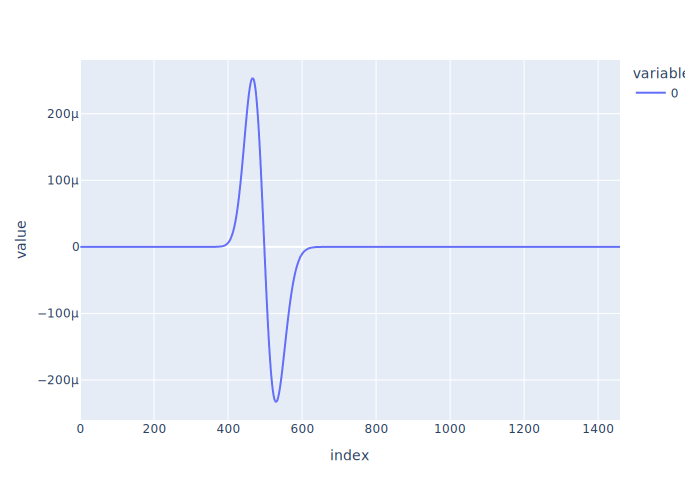

In [106]:
px.line(employed_holding_time_transition_probs)

In [107]:
employed_holding_time_transition_probs[450]

Array(0.00019569, dtype=float32)

In [111]:
jnp.exp(employed_holding_time_dist.log_prob(451)) - jnp.exp(employed_holding_time_dist.log_prob(450))

Array(0.00019868, dtype=float32, weak_type=True)

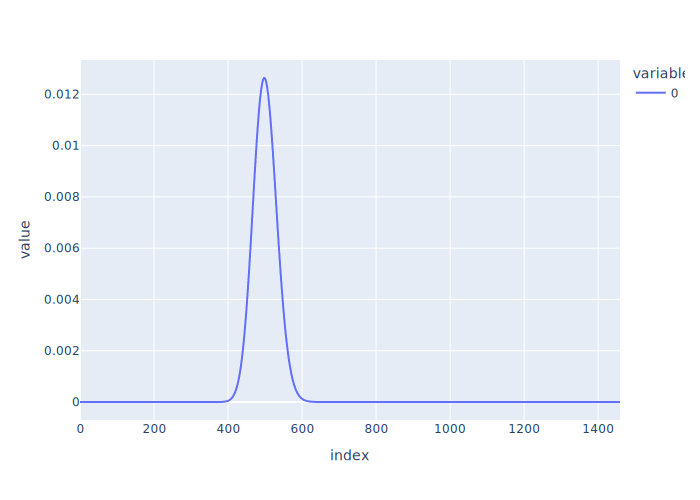

In [109]:
px.line(
    jnp.exp(employed_holding_time_dist.log_prob(t))
)

In [14]:
employed_holding_time_haz = calc_haz(
    log_probs=employed_holding_time_dist.log_prob(t),
    cdf_vals=employed_holding_time_dist.cdf(t)
)

In [ ]:

employed_holding_time_haz = jnp.exp(
    employed_holding_time_dist.log_prob(t)
) / (1 - employed_holding_time_dist.cdf(t))

unemployed_no_want_job_holding_time_haz = jnp.exp(
    unemployed_no_want_job_holding_time_dist.log_prob(t)
) / (1 - unemployed_no_want_job_holding_time_dist.cdf(t))

unemployed_want_job_holding_time_haz = jnp.exp(
    unemployed_want_job_holding_time_dist.log_prob(t)
) / (1 - unemployed_want_job_holding_time_dist.cdf(t))

In [11]:
surv = 1 - unemployed_want_job_holding_time_dist.cdf(t)

In [12]:
surv[400]

Array(0., dtype=float32, weak_type=True)

In [15]:
employed_holding_time_haz[400]

Array(4.842817e-05, dtype=float32)

In [16]:
px.line(employed_holding_time_haz)

In [26]:
px.line(employed_holding_time_transition_probs - employed_holding_time_haz)

In [30]:
(employed_holding_time_dist.cdf(673 + 1) - employed_holding_time_dist.cdf(673))

Array(5.9604645e-08, dtype=float32, weak_type=True)

In [31]:
1-employed_holding_time_dist.cdf(673)

Array(3.5762787e-07, dtype=float32, weak_type=True)

# Example Transition Matrix

In [116]:
def get_transition_mats(t):
    trans_mats = jnp.broadcast_to(
        array=jnp.array([
            [0.9, 0.001, 0.099],
            [0.00001, 0.6, 0.39999],
            [0.2, 0.5, 0.3]
        ]),
        shape=(t.shape[0], 3, 3)
    )
    return trans_mats

In [128]:
t=jnp.arange(1)
initial_state_vec = jnp.array([
    [1, 0, 0]
])

transition_mats = get_transition_mats(t=t)

state_vec = initial_state_vec
for ti in range(len(t)):
    state_vec = state_vec @ transition_mats[ti, :, :]
    
print(state_vec)

[[0.9   0.001 0.099]]
